In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from tqdm import tqdm
from skimage.color import label2rgb
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from matplotlib.lines import Line2D
import geopandas as gpd
from orinoco import get_cropped_profile, get_extent, make_map, rasterize_shapes_to_array, apply_func_to_superpixels
from rasterio.transform import rowcol
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', family='serif', size=20)

In [2]:
tiles = ['NH15', 'NH16', 'NR08']

In [112]:
tile_name = tiles[1]
slice_index = 1

In [113]:
out = Path('out')
grwl_data = Path('grwl_data')

tile_dir = out/tile_name
tile_dir_4326 = out/f'{tile_name}_4326'

In [114]:
list(tile_dir_4326.glob('*'))

[PosixPath('out/NH16_4326/distance.tif'),
 PosixPath('out/NH16_4326/ocean_mask.tif'),
 PosixPath('out/NH16_4326/segments.tif'),
 PosixPath('out/NH16_4326/water_mask.tif')]

In [115]:
with rasterio.open(tile_dir/'segments.tif') as ds:
    segments = ds.read(1)
    profile = ds.profile

with rasterio.open(tile_dir/'water_mask.tif') as ds:
    water_mask = ds.read(1)
    profile= ds.profile

In [116]:
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 19671, 'height': 14906, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(30.0, 0.0, 204855.0,
       0.0, -30.0, 3544455.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

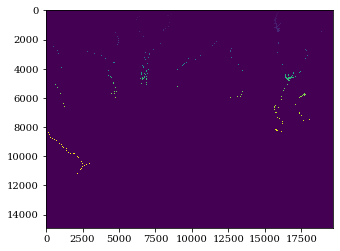

In [117]:
plt.imshow(segments)

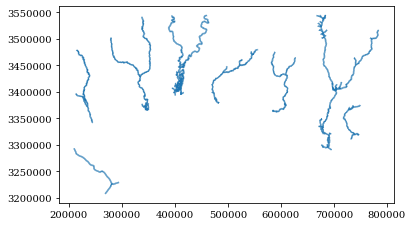

In [118]:

edges_fmm = gpd.read_file(tile_dir/'orinoco_edges.geojson')
edges_fmm.plot()

In [119]:
edges_grwl = gpd.read_file(grwl_data/'centerlines'/tile_name).to_crs(edges_fmm.crs)


In [120]:
xmin, ymin, xmax, ymax = edges_fmm.total_bounds
xmin, ymin, xmax, ymax

(209943.0, 3207773.25, 784008.1578947369, 3544395.566037736)

In [121]:
rows, cols = rowcol(profile['transform'], [xmin, xmax], [ymax, ymin])
rows, cols

([1, 11222], [169, 19305])

In [143]:
# buffer
N = 5
sy = np.s_[max(rows[0]-N, 0): rows[1]+N]
sx = np.s_[max(cols[0]-N, 0): cols[1]+N]

In [144]:
cropped_profile = get_cropped_profile(profile, sx, sy)
cropped_profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 19146, 'height': 11227, 'count': 1, 'crs': CRS.from_epsg(32616), 'transform': Affine(30.0, 0.0, 209775.0,
       0.0, -30.0, 3544455.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [145]:
sy

slice(0, 11227, None)

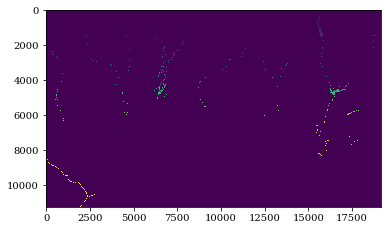

In [146]:
with rasterio.open(tile_dir/'segments.tif') as ds:
    segments = ds.read(1)
    
segments = segments[sy, sx]
plt.imshow(segments)

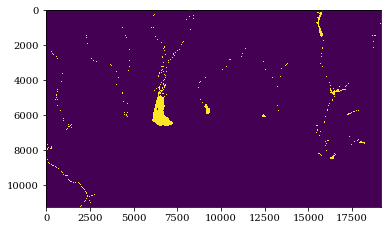

In [147]:
plt.imshow(water_mask[sy, sx])

In [148]:
extent = get_extent(cropped_profile['transform'], cropped_profile['width'], cropped_profile['height'])
extent

[209775.0, 784155.0, 3544455.0, 3207645.0]

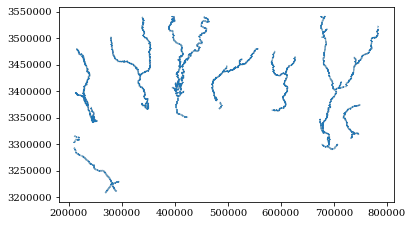

In [149]:
edges_grwl_c = edges_grwl.cx[extent[0]: extent[1], extent[3]: extent[2]]
edges_grwl_c.plot()

In [150]:
edges_grwl_c.head()

,utm_east,utm_north,width_m,nchannels,segmentID,segmentInd,lakeFlag,lon,lat,elev_m,geometry
0,214800,3479910,96,1.0,0,4718,0.0,-89.999853,31.418931,58,LINESTRING (214801.175886281 3479911.175880176...
1,214830,3479940,108,1.0,0,4719,0.0,-89.999552,31.419204,58,LINESTRING (214830.000001504 3479939.999999999...
2,214860,3479970,87,1.0,0,4720,0.0,-89.999246,31.419481,58,LINESTRING (214860.0000015026 3479969.99999999...
3,214890,3480000,87,1.0,0,4721,0.0,-89.999254,31.419752,58,LINESTRING (214890.0000015037 3479999.99999999...
4,214860,3480030,129,1.0,0,4722,0.0,-89.999263,31.420022,58,LINESTRING (214860.0000015028 3480029.99999999...


In [151]:
edges_grwl_c.width_m.unique()

array([  96,  108,   87, ..., 2493, 2165, 2132])

In [152]:
widths_raster_grwl = rasterize_shapes_to_array(edges_grwl_c.geometry.buffer(1e-7).tolist(),
                                              edges_grwl_c.width_m.tolist(),
                                              cropped_profile,
                                              all_touched=True)
widths_raster_grwl[widths_raster_grwl == 0] = np.nan

In [153]:
nodes_fmm = gpd.read_file(tile_dir/'orinoco_nodes.geojson')
nodes_fmm.head()

,label,meters_to_interface,x,y,interface_adj,graph_degree,width,cc_id,geometry
0,7579,5357.155910,408660.840000,3.404670e+06,False,4,309.411255,NaN,POINT (408660.84 3404670.12)
1,7599,5096.325180,408565.243902,3.404427e+06,False,2,186.333077,NaN,POINT (408565.243902439 3404427.43902439)
2,7617,4790.619929,408617.093023,3.404126e+06,False,2,104.164079,NaN,POINT (408617.0930232558 3404126.162790698)
3,7639,4486.757027,408640.227273,3.403823e+06,False,2,104.164079,NaN,POINT (408640.2272727273 3403823.181818182)
4,7662,4185.377417,408663.139535,3.403523e+06,False,2,104.164079,NaN,POINT (408663.1395348837 3403522.674418604)


In [154]:
segment_labels_from_nodes = nodes_fmm.label.values
widths_fmm = nodes_fmm.width.values


In [155]:
def nan_mean(arr):
    nan_indices = np.isnan(arr)
    if np.sum(~nan_indices) > 0:
        return np.mean(arr[~nan_indices])
    else:
        return np.nan

In [156]:
segments.shape,widths_raster_grwl.shape

((11227, 19146), (11227, 19146))

In [157]:
width_features_grwl = apply_func_to_superpixels(nan_mean, segments, widths_raster_grwl)

In [158]:
segments_unique_for_apply = np.unique(segments)
segments_unique_for_apply.shape, width_features_grwl.shape

((11482,), (11482, 1))

In [159]:
grwl_width_slice = np.isin(segments_unique_for_apply, segment_labels_from_nodes) & ~np.isnan(width_features_grwl.ravel())

In [160]:
grwl_no_nan_width_labels = segments_unique_for_apply[~np.isnan(width_features_grwl.ravel())]
fmm_width_slice = np.isin(segment_labels_from_nodes, grwl_no_nan_width_labels)

In [161]:
fmm_labels_filtered = segment_labels_from_nodes[fmm_width_slice]
grwl_labels_filtered = segments_unique_for_apply[grwl_width_slice]

In [162]:
# len(set(grwl_labels_filtered).intersection(fmm_labels_filtered)), len(grwl_labels_filtered), len(fmm_labels_filtered)
set(grwl_labels_filtered) == set(fmm_labels_filtered)

True

In [163]:
grwl_labels_filtered[:10], fmm_labels_filtered[:10]

(array([ 90,  97, 105, 114, 117, 121, 123, 124, 127, 129], dtype=int32),
 array([7601, 7620, 7642, 7664, 7685, 7705, 7723, 7736, 7549, 7582]))

In [164]:
x = grwl_labels_filtered.copy()
y =fmm_labels_filtered.copy()

In [165]:
# https://stackoverflow.com/questions/8251541/numpy-for-every-element-in-one-array-find-the-index-in-another-array
xsorted = np.argsort(x)
ypos = np.searchsorted(x[xsorted], y)
indices = xsorted[ypos]

In [166]:
x[indices[0]], y[0]

(7601, 7601)

In [167]:
grwl_labels_filtered[indices][:10], fmm_labels_filtered[:10]

(array([7601, 7620, 7642, 7664, 7685, 7705, 7723, 7736, 7549, 7582],
       dtype=int32),
 array([7601, 7620, 7642, 7664, 7685, 7705, 7723, 7736, 7549, 7582]))

In [188]:
xx = width_features_grwl[np.isin(segments_unique_for_apply, grwl_labels_filtered)].ravel()
yy = widths_fmm[np.isin(segment_labels_from_nodes, grwl_labels_filtered)].ravel() - 60

In [189]:
ii = (np.abs(xx - yy) < 500)
xxx = xx[ii]
yyy = yy[ii]

(0, 1000)

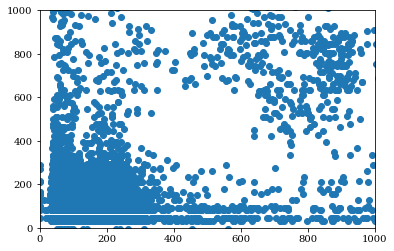

In [192]:
plt.scatter(xx, yy)
plt.xlim(0, 1000)
plt.ylim(0, 1000)

In [193]:
np.mean(xx - yy)

16.31271940958562